- PCA (주성분 분석) : 데이터 전처리 과정에 가까움, 비지도 학습을 적용한 차원 축소
  - 차원 축소 : 데이터의 전반적인 특성을 보존하면서 변수의 수를 줄임, 연산속도가 증가
    - 특성 선택 : 가장 중요한 특성들만 선택하여 기존의 데이터를 표현 (일부 변수를 버리게 됨)
    - 특성 추출 : 기존의 특성들을 이용하여 새로운 특성을 만들어냄 (파생변수 생성)
  - 기존의 변수를 조합하여 새로운 변수를 생성
    - PCA는 원본 연속형 변수의 분산을 최대한 설명할 수 있는 더 적은 갯수의 변수를 생성하는 것을 목표로 함
      - 분산 개념이 존재하지 않는 더미화된 명목형 변수에는 적용할 수 없음
  - sklearn.decomposition의 PCA 혹은 PCA 패키지를 사용

In [1]:
import sys
sys.path.append("Y:\Python\Mega_IT")

from yjk_module.preprocessing import *
from yjk_module.ml_module import *

In [2]:
from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

In [5]:
origin1 = pd.read_excel("./data/iris.xlsx")
origin1.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


- 독립변수만 추출
  - 차원축소는 독립변수에 대해서만 수행
- 스케일링
  - MinMax or Standard 스케일링이 필수

In [6]:
X = origin1.drop("Species", axis = 1)

In [7]:
X_p = my_standard_scaler(X)
X_p.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [8]:
estimator = PCA(n_components = 2)
pca = estimator.fit_transform(X_p)
pca[:5]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538]])

In [9]:
pca_df = pd.DataFrame(pca, columns = estimator.get_feature_names_out())
pca_df['target'] = origin1['Species']
pca_df.head()

,pca0,pca1,target
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


- 생성된 변수들의 설명력 확인 (설명된 분산)

In [10]:
estimator.explained_variance_ratio_, estimator.explained_variance_

(array([0.72962445, 0.22850762]), array([2.93808505, 0.9201649 ]))

- 파라미터 튜닝
  - n_components : 0~1로 지정하면 설명된 분산 비율 총합이 해당 값 이상으로 출력됨, 정수는 해당 수만큼의 컬럼 생성
  - n_components를 mle로, svd_solver를 auto or full 이면 Minka의 MLE방식 사용

In [11]:
estimator = PCA(random_state = 0)
params = {
    'n_components' : [0.95, 2, 3, 4, 'mle'], # 2 ~ 4 추천
    'svd_solver' : ['auto', 'full', 'arpack'],
    'tol' : [0, 0.1, 0.5, 1]
}

model = RandomizedSearchCV(estimator = estimator, param_distributions = params, n_iter = 10, cv = 5, random_state = 0)
model.fit(X_p)

print(model.best_params_)
print(model.best_score_)

{'tol': 0.5, 'svd_solver': 'auto', 'n_components': 3}
-3.9367123415295695


In [12]:
pca = model.best_estimator_.transform(X_p)
pca_df = pd.DataFrame(pca, columns = model.best_estimator_.get_feature_names_out())
pca_df['target'] = origin1['Species']
pca_df.head()

,pca0,pca1,pca2,target
0,-2.264703,0.480027,-0.127706,setosa
1,-2.080961,-0.674134,-0.234609,setosa
2,-2.364229,-0.341908,0.044201,setosa
3,-2.299384,-0.597395,0.091290,setosa
4,-2.389842,0.646835,0.015738,setosa


- 차원 축소 결과 해석 (시각화)

In [13]:
def biplot(score, coeff, pcax, pcay, labels=None):
    plt.figure(figsize = (10, 5), dpi = 150)
    pca1 = pcax - 1
    pca2 = pcay - 1
    xs = score[:, pca1]
    ys = score[:, pca2]
    n = score.shape[1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, pca1], coeff[i, pca2], color="r", alpha=0.5)
        if labels is None:
            plt.text(
                coeff[i, pca1] * 1.15,
                coeff[i, pca2] * 1.15,
                "Var" + str(i + 1),
                color="g",
                ha="center",
                va="center",
            )
        else:
            plt.text(
                coeff[i, pca1] * 1.15,
                coeff[i, pca2] * 1.15,
                labels[i],
                color="g",
                ha="center",
                va="center",
            )
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

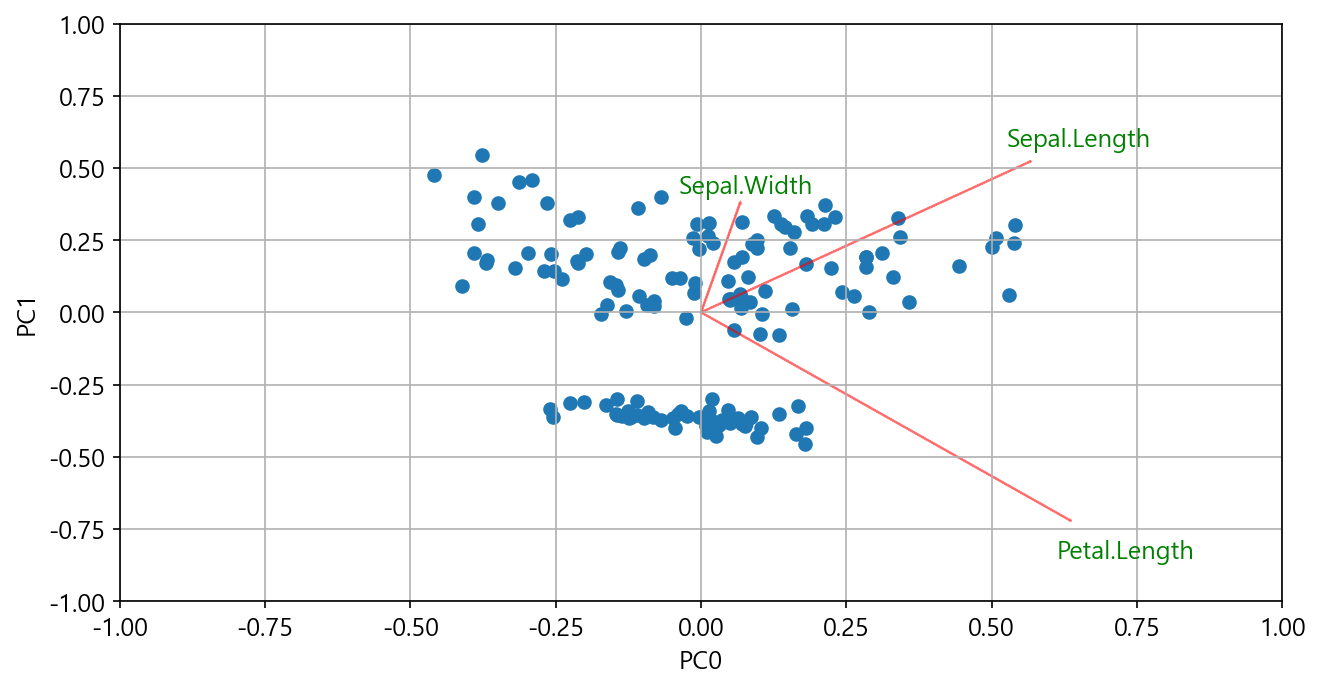

In [14]:
biplot(score=pca, coeff=model.best_estimator_.components_, pcax=0, pcay=1, labels=X_p.columns)

In [15]:
pca_df2 = my_labelling(pca_df, 'target')

+------------+---------+
| target     |   label |
|------------+---------|
| setosa     |       0 |
| versicolor |       1 |
| virginica  |       2 |
+------------+---------+


In [16]:
x_train, x_test, y_train, y_test = my_train_test_split(pca_df2, yname = 'target', test_size = 0.2, random_state = 0)

In [17]:
support = YjkClassifierSupport()

사용 가능한 모델 : ['LogisticRegression', 'SGDClassifier', 'KNeighborsClassifier', 'LinearSVC', 'SVC', 'GaussianNB', 'DecisionTreeClassifier', 'CatboostClassifier']


In [18]:
result_df = yjk_classifier_multi_gridsearch(support, x_train, y_train, x_test, y_test, randomized_search = True, randomized_iter = 30,
                                            secondary_score = ['precision', 'roc_auc'], include_proba = True)

LogisticRegression 모델 소요 시간 : 0:00:03
SGDClassifier 모델 소요 시간 : 0:00:01
KNeighborsClassifier 모델 소요 시간 : 0:00:00
LinearSVC 모델 소요 시간 : 0:00:00
SVC 모델 소요 시간 : 0:00:00
GaussianNB 모델 소요 시간 : 0:00:00
DecisionTreeClassifier 모델 소요 시간 : 0:00:00
총 소요 시간 : 0:00:06


In [19]:
result_df

,best_model,best_param,accuracy_train,accuracy_test,precision_train,precision_test,roc_auc_train,roc_auc_test
model_name,,,,,,,,
LogisticRegression,"LogisticRegression(C=0.001, max_iter=500, n_jo...","{'penalty': None, 'max_iter': 500, 'C': 0.001}",0.983333,1.000000,0.983415,1.000000,0.998959,1.000000
KNeighborsClassifier,"KNeighborsClassifier(n_jobs=-1, n_neighbors=6)","{'weights': 'uniform', 'p': 2, 'n_neighbors': 6}",0.966667,1.000000,0.966422,1.000000,0.995102,1.000000
SVC,"SVC(C=1, degree=4, probability=True)","{'kernel': 'rbf', 'degree': 4, 'C': 1}",0.958333,1.000000,0.958180,1.000000,0.998334,1.000000
SGDClassifier,"SGDClassifier(alpha=0.01, early_stopping=True,...","{'tol': 0.001, 'penalty': None, 'max_iter': 10...",0.933333,0.966667,0.938131,0.952381,0.983628,0.996177
LinearSVC,"LinearSVC(C=10, dual=True, max_iter=10000, ran...","{'penalty': 'l2', 'max_iter': 10000, 'loss': '...",0.958333,0.966667,0.959259,0.976190,NaN,NaN
GaussianNB,GaussianNB(),{'var_smoothing': 1e-09},0.933333,0.900000,0.933661,0.876984,0.988756,0.977061
DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...","{'splitter': 'best', 'min_samples_split': 5, '...",0.991667,0.900000,0.991228,0.885714,0.999688,0.976412


LogisticRegression({'n_jobs': -1, 'random_state': 1234}) {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}
KNeighborsClassifier({'n_jobs': -1}) {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
SVC({'random_state': 1234}) {}
GaussianNB({}) {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
DecisionTreeClassifier({'random_state': 1234}) {'criterion': ['gini', 'entropy']}
SGDClassifier({'n_jobs': -1, 'random_state': 1234, 'early_stopping': True}) {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 3000, 4000, 5000], 'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.1, 0.5]}
+------------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                        |   정확도(Accuracy) |   정밀도(Precis

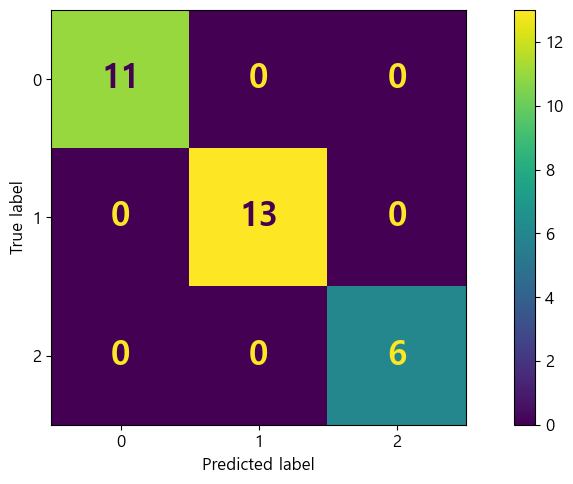


[학습곡선]


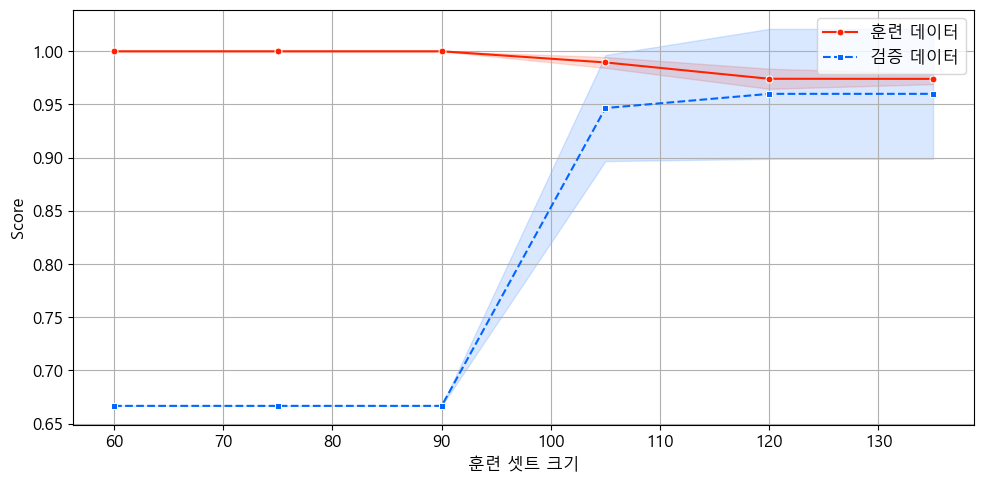

+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       0 | pca2       | 1.01267 |
|  0 | target     |       0 | pca0       | 1.10313 |
|  1 | target     |       0 | pca1       | 1.10476 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       1 | pca2       | 1.01267 |
|  0 | target     |       1 | pca0       | 1.10313 |
|  1 | target     |       1 | pca1       | 1.10476 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       2 | pca2       | 1.01267 |
|  0 | target     |       2 | pca0       | 1.10313 |
|  1 | target    

{'SVC': SVC(random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=1234),
 'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=100, max_iter=1000, n_jobs=-1, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7,
                      weights='distance'),
 'SGDClassifier': SGDClassifier(early_stopping=True, eta0=0.5, learning_rate='adaptive',
               loss='modified_huber', max_iter=4000, n_jobs=-1,
               penalty='elasticnet', random_state=1234),
 'best': SVC(random_state=1234)}

In [20]:
my_classification(x_train, y_train, x_test, y_test)

- pca 패키지

In [21]:
from pca import pca

In [22]:
model = pca(n_components = 3, normalize = True, verbose = None)
result = model.fit_transform(X_p)

In [23]:
result

{'loadings':      Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
 PC1      0.521066    -0.269347      0.580413     0.564857
 PC2      0.377418     0.923296      0.024492     0.066942
 PC3     -0.719566     0.244382      0.142126     0.634273,
 'PC':           PC1       PC2       PC3
 0   -2.264703  0.480027 -0.127706
 1   -2.080961 -0.674134 -0.234609
 2   -2.364229 -0.341908  0.044201
 3   -2.299384 -0.597395  0.091290
 4   -2.389842  0.646835  0.015738
 ..        ...       ...       ...
 145  1.870503  0.386966  0.256274
 146  1.564580 -0.896687 -0.026371
 147  1.521170  0.269069  0.180178
 148  1.372788  1.011254  0.933395
 149  0.960656 -0.024332  0.528249
 
 [150 rows x 3 columns],
 'explained_var': array([0.72962445, 0.95813207, 0.99482129]),
 'variance_ratio': array([0.72962445, 0.22850762, 0.03668922]),
 'model': PCA(n_components=3),
 'scaler': StandardScaler(),
 'pcp': 0.9948212908928451,
 'topfeat':     PC       feature   loading  type
 0  PC1  Petal.Length  0.580413  b

- 결과는 딕셔너리로 제공

In [24]:
result.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

- PCA 결과

In [25]:
result['PC']

,PC1,PC2,PC3
0,-2.264703,0.480027,-0.127706
1,-2.080961,-0.674134,-0.234609
2,-2.364229,-0.341908,0.044201
3,-2.299384,-0.597395,0.091290
4,-2.389842,0.646835,0.015738
...,...,...,...
145,1.870503,0.386966,0.256274
146,1.564580,-0.896687,-0.026371
147,1.521170,0.269069,0.180178
148,1.372788,1.011254,0.933395


- 각 주성분에 영향을 주는 변수 확인

In [26]:
result['loadings']

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
PC1,0.521066,-0.269347,0.580413,0.564857
PC2,0.377418,0.923296,0.024492,0.066942
PC3,-0.719566,0.244382,0.142126,0.634273


- 각 주성분을 형성하는 가장 큰 영향을 준 변수

In [27]:
result['topfeat']

,PC,feature,loading,type
0,PC1,Petal.Length,0.580413,best
1,PC2,Sepal.Width,0.923296,best
2,PC3,Sepal.Length,-0.719566,best
3,PC3,Petal.Width,0.634273,weak


- 주성분 선정 근거

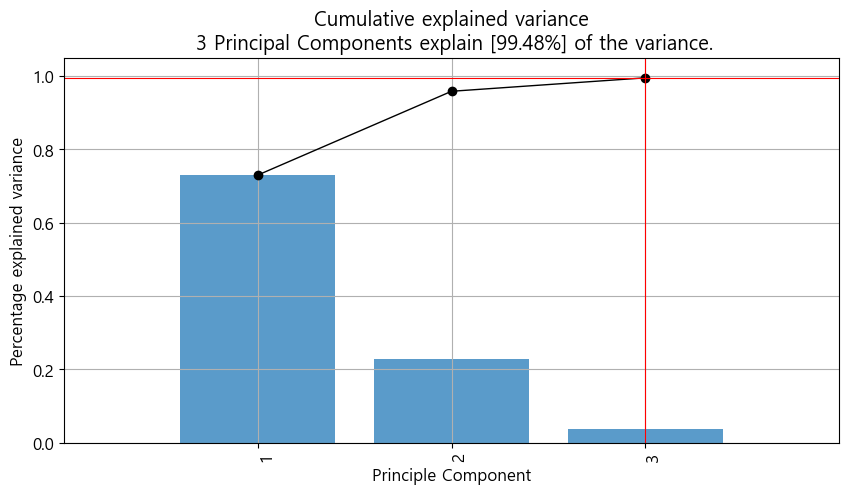

In [28]:
fig, ax = model.plot()
fig.set_size_inches(10, 5)
fig.set_dpi(100)
plt.show()

[scatterd] >INFO> Create scatterplot


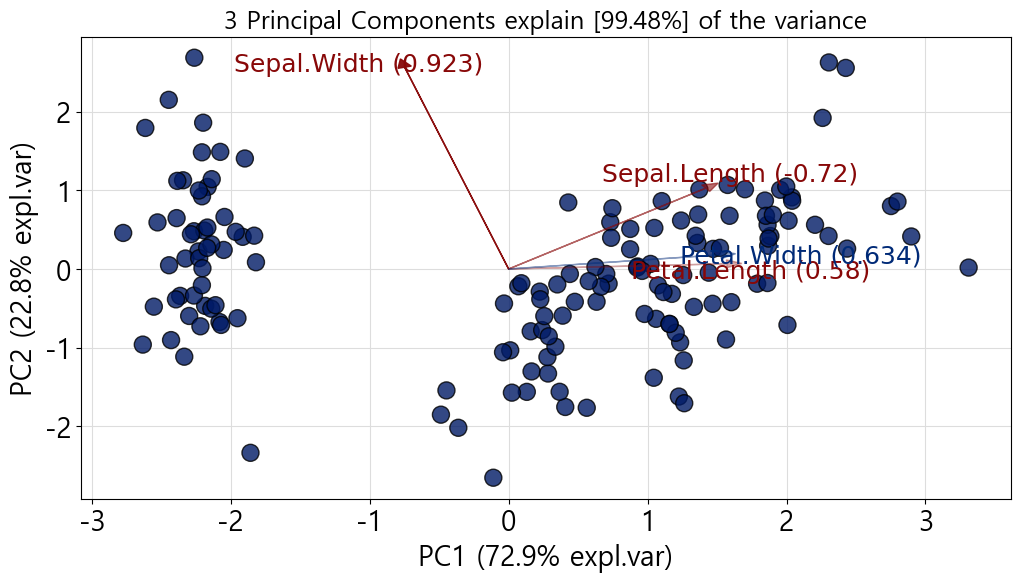

In [29]:
fig, ax = model.biplot()
fig.set_size_inches(12, 6)
fig.set_dpi(100)
plt.show()

In [35]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

In [30]:
result_df = result['PC'].copy()
result_df['target'] = origin1['Species']
result_df = my_labelling(result_df, 'target')

+------------+---------+
| target     |   label |
|------------+---------|
| setosa     |       0 |
| versicolor |       1 |
| virginica  |       2 |
+------------+---------+


In [31]:
x_train, x_test, y_train, y_test = my_train_test_split(result_df, yname = 'target', test_size = 0.2, random_state = 0)

In [32]:
results = yjk_classifier_multi_gridsearch(support, x_train, y_train, x_test, y_test, randomized_search = True)

LogisticRegression 모델 소요 시간 : 0:00:00
SGDClassifier 모델 소요 시간 : 0:00:03
KNeighborsClassifier 모델 소요 시간 : 0:00:00
LinearSVC 모델 소요 시간 : 0:00:00
SVC 모델 소요 시간 : 0:00:00
GaussianNB 모델 소요 시간 : 0:00:00
DecisionTreeClassifier 모델 소요 시간 : 0:00:00
총 소요 시간 : 0:00:05


In [33]:
results

,best_model,best_param,accuracy_train,accuracy_test
model_name,,,,
LogisticRegression,"LogisticRegression(C=0.001, n_jobs=-1, penalty...","{'penalty': None, 'max_iter': 100, 'C': 0.001}",0.983333,1.000000
KNeighborsClassifier,"KNeighborsClassifier(n_jobs=-1, n_neighbors=6)","{'weights': 'uniform', 'p': 2, 'n_neighbors': 6}",0.966667,1.000000
SVC,"SVC(C=1, degree=2)","{'kernel': 'rbf', 'degree': 2, 'C': 1}",0.958333,1.000000
SGDClassifier,"SGDClassifier(alpha=0.01, early_stopping=True,...","{'tol': 0.0001, 'penalty': 'elasticnet', 'max_...",0.966667,0.966667
LinearSVC,"LinearSVC(C=10, dual=False, random_state=0)","{'penalty': 'l2', 'max_iter': 1000, 'loss': 's...",0.958333,0.966667
DecisionTreeClassifier,"DecisionTreeClassifier(max_depth=7, min_sample...","{'splitter': 'random', 'min_samples_split': 10...",0.950000,0.933333
GaussianNB,GaussianNB(),{'var_smoothing': 1e-09},0.933333,0.900000


LogisticRegression({'n_jobs': -1, 'random_state': 1234}) {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}
KNeighborsClassifier({'n_jobs': -1}) {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
SVC({'random_state': 1234}) {}
GaussianNB({}) {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
DecisionTreeClassifier({'random_state': 1234}) {'criterion': ['gini', 'entropy']}
SGDClassifier({'n_jobs': -1, 'random_state': 1234, 'early_stopping': True}) {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 3000, 4000, 5000], 'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.1, 0.5]}
+------------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                        |   정확도(Accuracy) |   정밀도(Precis

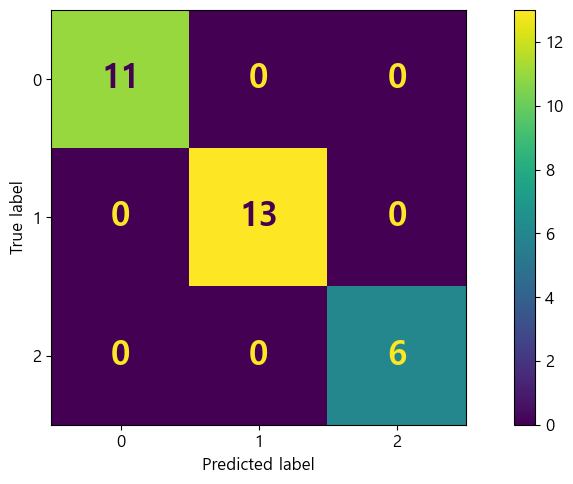


[학습곡선]


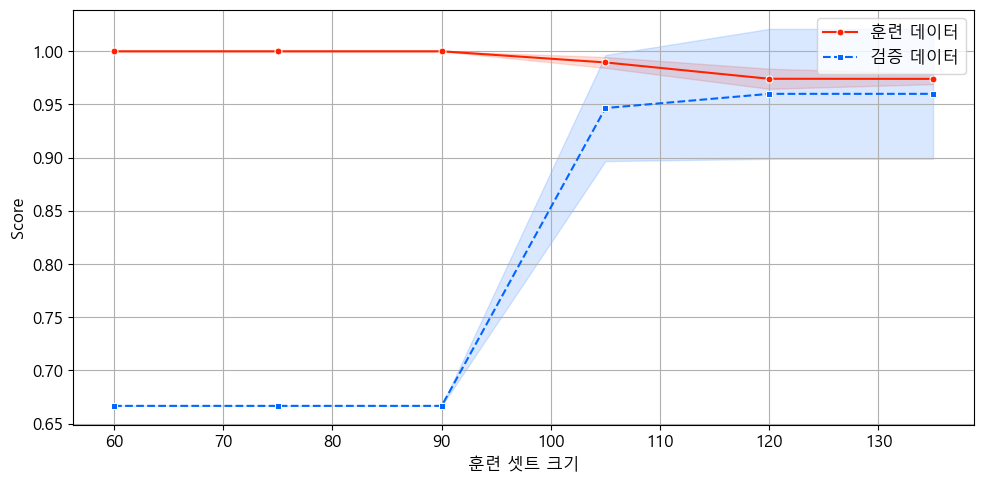

+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       0 | PC3        | 1.01267 |
|  0 | target     |       0 | PC1        | 1.10313 |
|  1 | target     |       0 | PC2        | 1.10476 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       1 | PC3        | 1.01267 |
|  0 | target     |       1 | PC1        | 1.10313 |
|  1 | target     |       1 | PC2        | 1.10476 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  2 | target     |       2 | PC3        | 1.01267 |
|  0 | target     |       2 | PC1        | 1.10313 |
|  1 | target    

{'SVC': SVC(random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=1234),
 'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=100, max_iter=1000, n_jobs=-1, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7,
                      weights='distance'),
 'SGDClassifier': SGDClassifier(early_stopping=True, eta0=0.5, learning_rate='adaptive',
               loss='modified_huber', max_iter=2000, n_jobs=-1,
               random_state=1234),
 'best': SVC(random_state=1234)}

In [36]:
my_classification(x_train, y_train, x_test, y_test)